## Problem Statement
Big Pharma is a large pharmaceutical distribution company in Germany. They restock their warehouses monthly but have been running into issues with overstocking and under-stocking products. You were employed as a data scientist to help find a solution to this problem. The sales team has provided you with data to get started on implementing your solution.
The data required for this is in the accompanying attachment data.zip.


### Metadata
1.	Date: The date a product was purchased
2.	Product ID: The ID for the product
3.	Stock Demand: The quantity of product purchased (unit is in boxes)

### Task
The data provided includes product demand from October 2020 to October 2021. Your task is to forecast the quantity of products the company should purchase for their warehouses in the coming month. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb

import datetime as dt

import featuretools as ft
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (f1_score, accuracy_score, recall_score, precision_score,
                            confusion_matrix,roc_auc_score,plot_confusion_matrix)


In [2]:
df = pd.read_excel('pharmaceutical-sales-demand.xlsx')
df.head()

,Date,Product ID,Stock Demand
0,2020-10-05,I6DO4,-1
1,2020-10-05,O40SR,16
2,2020-10-19,Y03MS,306
3,2020-10-08,B0OR2,307
4,2020-10-02,EIM03,6


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1048575 non-null  datetime64[ns]
 1   Product ID    1048575 non-null  object        
 2   Stock Demand  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.0+ MB


1048575 total number of records. Features are in their correct data types

In [4]:
df.isna().sum().sum()

0

There are no missing values

In [5]:
df.duplicated().sum()

8916

There are 8916 duplicated records in the dataset. 

In [6]:
df.size

3145725

In [7]:
df.shape

(1048575, 3)

In [8]:
df.describe(include='all',datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Date,1048575,NaN,NaN,NaN,2021-02-21 07:34:04.746441728,2020-10-01 00:00:00,2020-12-10 00:00:00,2021-02-23 00:00:00,2021-05-04 00:00:00,2021-07-31 00:00:00,NaN
Product ID,1048575,7798,N0SI1,1482,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock Demand,1048575.0,NaN,NaN,NaN,79.705856,-12226.0,3.0,9.0,31.0,149004.0,610.023009


- The earliest date is 2020-10-01 and the lastest date is 2021-07-31. 
- There are 7798 Products with _N0SI1_ as the frequently occuring product in the dataset
- The minimum and maximum purchased stock quantity is -12226 and 149004. 
- Average Stock Demand is ~79.70, however 75% of the time, the stock in demand is 31 or lower.


# Data Cleaning

Analysing the dataset, there are a few data cleaning issues identified. We will attempt to clean the data at this stage

#### Identified Data Quality Issues 
1. Duplicated Entries




### Cleaning Data 

##### Issue 1

##### Define : 
 The duplicated entries may ruin our train/test split during model building. This may affect the performance of our model.
 
**Remove the duplicated records in the dataset**

##### Code : 

In [9]:
df.drop_duplicates(inplace=True)

##### Test :

In [10]:
df.duplicated().sum()

0

There are no duplicates in the dataset

##### Define : 
 A negative stock demand value could mean one of many things with a few listed below :
1. the product was returned. 
2. the value was entered in error.

Since I am unable to determine the actual reason, I will leave them as is



In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1039659 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1039659 non-null  datetime64[ns]
 1   Product ID    1039659 non-null  object        
 2   Stock Demand  1039659 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 31.7+ MB


In [12]:
#Let's check the proportion of outlies in the dataset
def data_whiskers(val):
    x_val = pd.Series(sorted(val))
    Q3 = x_val.quantile(0.75)
    Q1 = x_val.quantile(0.25)
    
    #interquartile range
    IQR = Q3 - Q1
    lower_whisker = Q1 - (1.5*IQR)
    upper_whisker = Q3 + (1.5*IQR)
    
    return lower_whisker, upper_whisker

In [13]:
LOW, HIGH = data_whiskers(df['Stock Demand'])
print(f'Lower Whisker : {LOW}')
print(f'Upper Whisker : {HIGH}')

Lower Whisker : -39.0
Upper Whisker : 73.0


In [14]:
tot_no_of_outlier = ((df['Stock Demand'] > HIGH) | (df['Stock Demand'] < LOW)).sum()
outlier_proportion = tot_no_of_outlier/len(df['Stock Demand'])
print(f'Proportion of outliers in dataset {round(outlier_proportion * 100,2)}%')

Proportion of outliers in dataset 14.65%


There outliers in the dataset make up ~14.65% of the data. 

Text(0.5, 1.0, 'Distribution of Stock Demand')

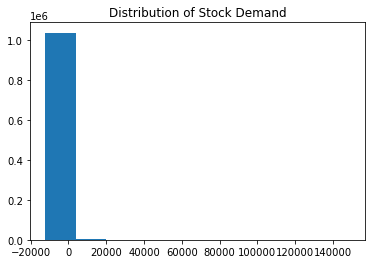

In [15]:
plt.hist(df['Stock Demand'], 10);
plt.title('Distribution of Stock Demand')

The distribution is highly skewed to the right with almost all the observation concentrated on the left. 

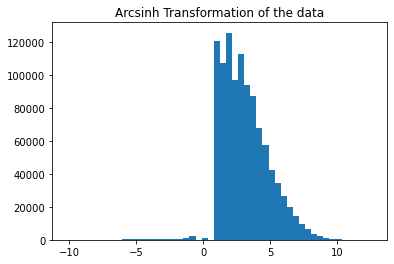

In [16]:
plt.hist(np.arcsinh(df['Stock Demand']),50);
plt.title('Arcsinh Transformation of the data');


In [17]:
df['Product ID'].value_counts()

N0SI1    1368
ET0N1    1171
V0EL1    1170
1PO0L    1157
AL10C    1156
         ... 
93NT8       1
A4N4T       1
NT433       1
T32N3       1
0KS1A       1
Name: Product ID, Length: 7798, dtype: int64

In [18]:
#Group data by product type. 

df.groupby('Product ID')['Date'].count()

Product ID
1970-04-01 00:00:00      1
2022-03-23 00:00:00     23
2022-03-30 00:00:00    111
0010R                   13
001NT                   14
                      ... 
ZR0D5                  109
ZR20A                  133
ZRD36                  188
ZV0I1                  191
ZVI02                  152
Name: Date, Length: 7798, dtype: int64

There are some product types represented as date time format. This need to be corrected. 

In [19]:
# Applying a function to convert data time product values to null
df['Product ID'] = df["Product ID"].apply(lambda x: np.nan if isinstance(x,dt.datetime) else x)

In [20]:
# Checking for missing values in Product_ID column
df['Product ID'].isnull().sum()

135

There are 135 missing values in the product column. I can fill the values with the mode or drop the entire rocords from the dataset. 

In [21]:
#removing missing values from the dataset
df.dropna(inplace=True)

In [22]:
# Confirm if there are no more missing value
print(f'Total no of missing values in dataset: {df.isnull().sum().sum()}')
print('------------------------ \n')

print(df.info())


Total no of missing values in dataset: 0
------------------------ 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1039524 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1039524 non-null  datetime64[ns]
 1   Product ID    1039524 non-null  object        
 2   Stock Demand  1039524 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 31.7+ MB
None


# Defining the Prediction Problem 
Due to the huge outliers and the percentage of outlier proportion, we will frame the problem as a classification problem and set a threshold. Products whose total stock demand exceed the threshold will be labeled for restocking and vice versa. 

##### Data Preprocessing

In [23]:
# Function to make total product sales in a month
# the default threshold for labeling the data is 1000.
def total_monthly_sales(start_date, end_date,threshold=1000):
    
    #Unique products that existed before start date
    products = df[df['Date'] < start_date]['Product ID'].unique()
    
    #create a dataframe for such products
    prod_temp = pd.DataFrame({'Product ID':products})
    
    #get total sales for the period for all products in product pool(products before start date)
    total_sales = df[df['Product ID'].isin(products) & 
                (df['Date']> start_date) & 
                (df['Date'] < end_date)].groupby('Product ID')['Stock Demand'].sum().reset_index()
    
    #add the total sales data to the product data
    total_sales = total_sales.merge(prod_temp, on ='Product ID', how='right')
    
    #Products that were no purchased at least once in the month under review is filled with 0
    total_sales['total_sale'] = total_sales['Stock Demand'].fillna(0)
    
    #set cutoff time to beginning of the period
    total_sales['cutoff_time'] = pd.to_datetime(start_date)
    
    #create dataframe
    total_sales = total_sales[['Product ID', 'cutoff_time', 'total_sale']]
    
    #Use threshold to set labels for the dataset
    total_sales['label'] = (total_sales['total_sale'] > threshold).astype(int)
    
    return total_sales
    

In [24]:
#2020-10-01
oct2020_sales = total_monthly_sales(dt.datetime(2020,10,1), dt.datetime(2020,11,1))

In [25]:
#total sales for the month of october
nov2020_sales = total_monthly_sales(dt.datetime(2020,11,1), dt.datetime(2020,12,1))

In [26]:
nov2020_sales.head()

,Product ID,cutoff_time,total_sale,label
0,I6DO4,2020-11-01,0.0,0
1,O40SR,2020-11-01,4899.0,1
2,Y03MS,2020-11-01,5544.0,1
3,B0OR2,2020-11-01,3828.0,1
4,EIM03,2020-11-01,426.0,0


Text(0.5, 1.0, 'Label Distribution for November')

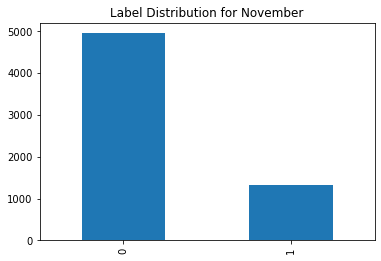

In [27]:
nov2020_sales.label.value_counts().plot.bar()
plt.title('Label Distribution for November')

In [28]:
print(f'Ratio of labels: \n{nov2020_sales.label.value_counts(normalize=True)}')

Ratio of labels: 
0    0.78825
1    0.21175
Name: label, dtype: float64


In [29]:
nov2020_sales.label.value_counts()

0    4951
1    1330
Name: label, dtype: int64

The sales of ~78% of the products did not exceed 1000 for the month of November 2020. This presents an imbalanced classification problem . We will be mindful of the evaluation metric during model building

In [30]:
df.Date.describe(datetime_is_numeric=True)['max'].date()

datetime.date(2021, 7, 31)

In [31]:
#Making labels for the data for each month
dec2020_sales = total_monthly_sales(dt.datetime(2020,12,1), dt.datetime(2021,1,1))
jan2021_sales = total_monthly_sales(dt.datetime(2021,1,1), dt.datetime(2021,2,1))
feb2021_sales = total_monthly_sales(dt.datetime(2021,2,1), dt.datetime(2021,3,1))
mar2021_sales = total_monthly_sales(dt.datetime(2021,3,1), dt.datetime(2021,4,1))
apr2021_sales = total_monthly_sales(dt.datetime(2021,4,1), dt.datetime(2021,5,1))
may2021_sales = total_monthly_sales(dt.datetime(2021,5,1), dt.datetime(2021,6,1))
jun2021_sales = total_monthly_sales(dt.datetime(2021,6,1), dt.datetime(2021,7,1))
jul2021_sales = total_monthly_sales(dt.datetime(2021,7,1), dt.datetime(2021,8,1))


In [32]:
#Create one master dataframe by stacking all the monthly dataframes together
data_labels = pd.concat([nov2020_sales, dec2020_sales, jan2021_sales, feb2021_sales, mar2021_sales, apr2021_sales, may2021_sales,
                        jun2021_sales, jul2021_sales], axis=0)

In [33]:
data_labels['label'].value_counts(normalize=True)

0    0.840053
1    0.159947
Name: label, dtype: float64

In [34]:
# Examine Product Sales by month
plot_label = data_labels.copy()
plot_label['period'] = plot_label['cutoff_time'].dt.to_period('M')

<AxesSubplot:xlabel='period', ylabel='total_sale'>

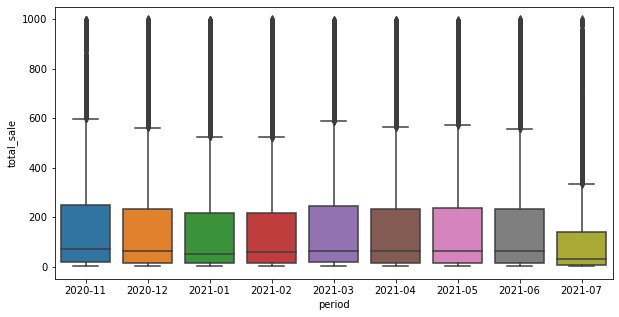

In [35]:
# plot distribution of sales by month
plt.figure(figsize=(10,5))
sb.boxplot(x='period', y='total_sale',
          data = plot_label[(plot_label['total_sale'] > 0) & (plot_label['total_sale'] < 1000)])

The median of the distribution for each month closely follows each other. The distribution is stationary over the period

In [36]:
# Zoom in on one product
data_labels.loc[data_labels['Product ID'] =='O40SR']

,Product ID,cutoff_time,total_sale,label
1,O40SR,2020-11-01,4899.0,1
1,O40SR,2020-12-01,4744.0,1
1,O40SR,2021-01-01,448.0,0
1,O40SR,2021-02-01,3023.0,1
1,O40SR,2021-03-01,2276.0,1
1,O40SR,2021-04-01,1295.0,1
1,O40SR,2021-05-01,445.0,0
1,O40SR,2021-06-01,2744.0,1
1,O40SR,2021-07-01,500.0,0


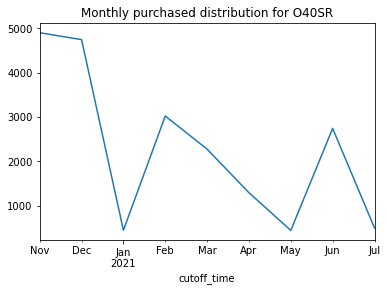

In [37]:
#Check monthly purchases for the product O40SR
data_labels.loc[data_labels['Product ID'] =='O40SR'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for O40SR');

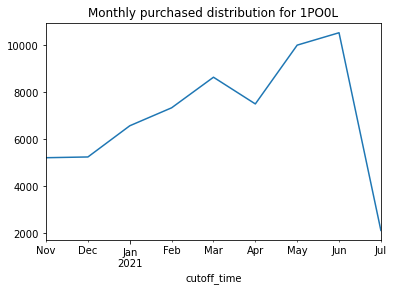

In [38]:
data_labels.loc[data_labels['Product ID'] =='1PO0L'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for 1PO0L');

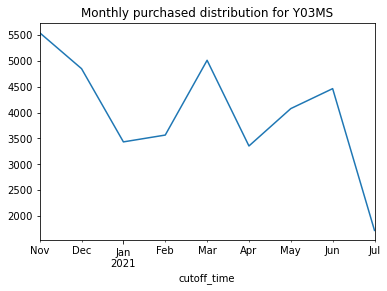

In [39]:
data_labels.loc[data_labels['Product ID'] =='Y03MS'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for Y03MS');

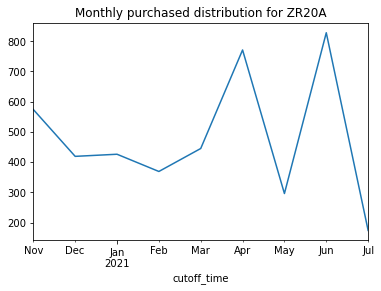

In [40]:
data_labels.loc[data_labels['Product ID'] =='ZR20A'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for ZR20A');

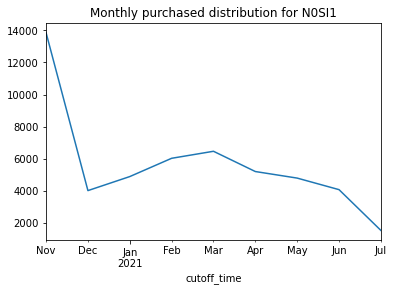

In [41]:
data_labels.loc[data_labels['Product ID'] =='N0SI1'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for N0SI1');

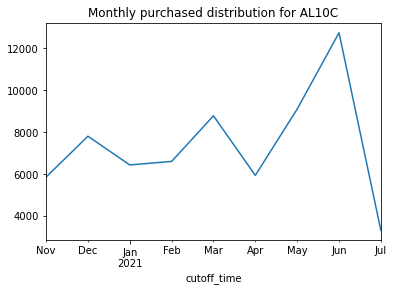

In [42]:
data_labels.loc[data_labels['Product ID'] =='AL10C'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for AL10C');

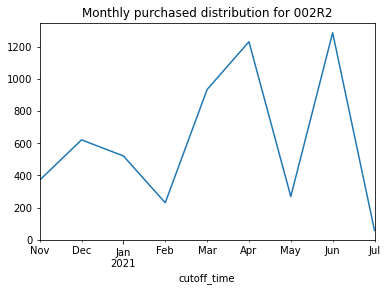

In [43]:
data_labels.loc[data_labels['Product ID'] =='002R2'].set_index('cutoff_time')['total_sale'].plot()
plt.title('Monthly purchased distribution for 002R2');

# Feature Engineering

Create new features

In [44]:
es = ft.EntitySet(id='Sales log')

es.entity_from_dataframe('sales',
                        dataframe=df,
                        index='sales_index',
                        time_index='Date')

C:\Users\mappiagyei\Anaconda3\lib\site-packages\featuretools\entityset\entity.py:462: UserWarning: index sales_index not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: Sales log
  Entities:
    sales [Rows: 1039524, Columns: 4]
  Relationships:
    No relationships

In [45]:
es['sales'].df.head()

,sales_index,Date,Product ID,Stock Demand
20,20,2020-10-01,235IR,5
67,67,2020-10-01,B10AR,712
137,137,2020-10-01,01ACU,30
152,152,2020-10-01,E0LV2,165
153,153,2020-10-01,RC0I1,31


In [46]:
es.normalize_entity(new_entity_id='products',
                   base_entity_id='sales',
                   index='Product ID',
                   )

Entityset: Sales log
  Entities:
    sales [Rows: 1039524, Columns: 4]
    products [Rows: 7795, Columns: 2]
  Relationships:
    sales.Product ID -> products.Product ID

In [47]:
es['products'].df.head()

,Product ID,first_sales_time
235IR,235IR,2020-10-01
B10AR,B10AR,2020-10-01
01ACU,01ACU,2020-10-01
E0LV2,E0LV2,2020-10-01
RC0I1,RC0I1,2020-10-01


# Deep Feature Synthesis

Use deep feature synthesis to generate new features that will be used in model building

In [48]:
data_labels.head()

,Product ID,cutoff_time,total_sale,label
0,I6DO4,2020-11-01,0.0,0
1,O40SR,2020-11-01,4899.0,1
2,Y03MS,2020-11-01,5544.0,1
3,B0OR2,2020-11-01,3828.0,1
4,EIM03,2020-11-01,426.0,0


In [49]:
#rename cutoff_time to time 
data_labels.rename(columns={'cutoff_time':'time'}, inplace=True)

In [50]:
data_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64434 entries, 0 to 7699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Product ID  64434 non-null  object        
 1   time        64434 non-null  datetime64[ns]
 2   total_sale  64434 non-null  float64       
 3   label       64434 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(1)
memory usage: 2.2+ MB


In [51]:
feature_mat, feature_names = ft.dfs(entityset=es, target_entity='products',
                                   cutoff_time=data_labels, cutoff_time_in_index= True,
                                   chunk_size=len(data_labels), n_jobs=1,
                                   max_depth=1)

feature_mat.head()

,,COUNT(sales),MAX(sales.Stock Demand),MEAN(sales.Stock Demand),MIN(sales.Stock Demand),SKEW(sales.Stock Demand),STD(sales.Stock Demand),SUM(sales.Stock Demand),DAY(first_sales_time),MONTH(first_sales_time),WEEKDAY(first_sales_time),YEAR(first_sales_time),total_sale,label
Product ID,time,,,,,,,,,,,,,
I6DO4,2020-11-01,3,1,0.333333,-1,-1.732051,1.154701,1,5,10,0,2020,0.0,0
O40SR,2020-11-01,65,623,60.800000,-125,2.657129,146.629017,3952,1,10,3,2020,4899.0,1
Y03MS,2020-11-01,25,1098,177.560000,1,2.652076,238.346750,4439,1,10,3,2020,5544.0,1
B0OR2,2020-11-01,28,681,143.607143,2,2.070061,155.989871,4021,1,10,3,2020,3828.0,1
EIM03,2020-11-01,42,55,10.785714,1,2.641657,9.866266,453,1,10,3,2020,426.0,0


In [52]:
# Check feature matrix for one product

feature_mat.loc['O40SR',:]

,COUNT(sales),MAX(sales.Stock Demand),MEAN(sales.Stock Demand),MIN(sales.Stock Demand),SKEW(sales.Stock Demand),STD(sales.Stock Demand),SUM(sales.Stock Demand),DAY(first_sales_time),MONTH(first_sales_time),WEEKDAY(first_sales_time),YEAR(first_sales_time),total_sale,label
time,,,,,,,,,,,,,
2020-11-01,65,623,60.800000,-125,2.657129,146.629017,3952,1,10,3,2020,4899.0,1
2020-12-01,127,1470,69.716535,-125,4.476025,203.175384,8854,1,10,3,2020,4744.0,1
2021-01-01,176,1470,77.261364,-125,4.099232,211.652815,13598,1,10,3,2020,448.0,0
2021-02-01,228,1470,61.732456,-125,4.730702,188.080504,14075,1,10,3,2020,3023.0,1
2021-03-01,282,1470,60.670213,-125,4.800583,176.033767,17109,1,10,3,2020,2276.0,1
2021-04-01,343,1470,56.530612,-125,4.997464,164.294927,19390,1,10,3,2020,1295.0,1
2021-05-01,390,1470,53.038462,-125,5.178990,156.798205,20685,1,10,3,2020,445.0,0
2021-06-01,430,1470,49.139535,-125,5.440719,149.969287,21130,1,10,3,2020,2744.0,1
2021-07-01,482,1470,49.541494,-125,5.325326,146.743016,23879,1,10,3,2020,500.0,0


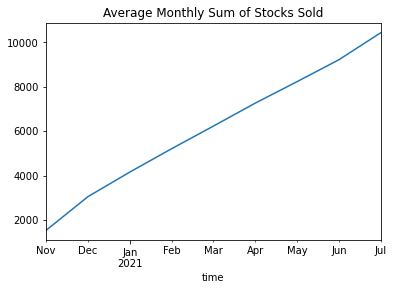

In [53]:
feature_mat.groupby('time')['SUM(sales.Stock Demand)'].mean().plot();
plt.title('Average Monthly Sum of Stocks Sold');

We see that the average monthly sum for stocks sold is increasing with time.

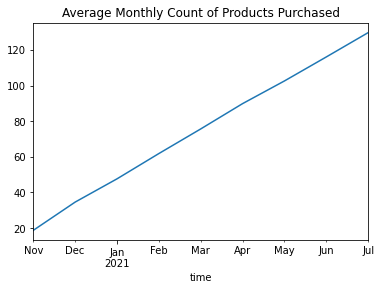

In [54]:
feature_mat.groupby('time')['COUNT(sales)'].mean().plot();
plt.title('Average Monthly Count of Products Purchased');

The total number of products as we progress through time also increases. That means we get more products to use in our model

In [55]:
feature_mat = pd.get_dummies(feature_mat).reset_index()

In [56]:
feature_mat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64434 entries, 0 to 64433
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Product ID                 64434 non-null  object        
 1   time                       64434 non-null  datetime64[ns]
 2   COUNT(sales)               64434 non-null  int64         
 3   MAX(sales.Stock Demand)    64434 non-null  int64         
 4   MEAN(sales.Stock Demand)   64434 non-null  float64       
 5   MIN(sales.Stock Demand)    64434 non-null  int64         
 6   SKEW(sales.Stock Demand)   59748 non-null  float64       
 7   STD(sales.Stock Demand)    61737 non-null  float64       
 8   SUM(sales.Stock Demand)    64434 non-null  int64         
 9   DAY(first_sales_time)      64434 non-null  int64         
 10  MONTH(first_sales_time)    64434 non-null  int64         
 11  WEEKDAY(first_sales_time)  64434 non-null  int64         
 12  YEAR

In [57]:
# Check Correlation between variables
ts_corr = feature_mat.corr().sort_values('total_sale')
ts_corr['total_sale']

MIN(sales.Stock Demand)     -0.226667
DAY(first_sales_time)       -0.112127
YEAR(first_sales_time)      -0.040875
MONTH(first_sales_time)      0.026085
WEEKDAY(first_sales_time)    0.065440
SKEW(sales.Stock Demand)     0.096222
COUNT(sales)                 0.197442
label                        0.397808
STD(sales.Stock Demand)      0.478129
MAX(sales.Stock Demand)      0.492160
MEAN(sales.Stock Demand)     0.634295
SUM(sales.Stock Demand)      0.649677
total_sale                   1.000000
Name: total_sale, dtype: float64

- Sum(sales.Stock Demand) has the highest correlation with total sale
- MIN(sales.Stock Demand) has the lowest

In [58]:
feature_mat.isna().sum()

Product ID                      0
time                            0
COUNT(sales)                    0
MAX(sales.Stock Demand)         0
MEAN(sales.Stock Demand)        0
MIN(sales.Stock Demand)         0
SKEW(sales.Stock Demand)     4686
STD(sales.Stock Demand)      2697
SUM(sales.Stock Demand)         0
DAY(first_sales_time)           0
MONTH(first_sales_time)         0
WEEKDAY(first_sales_time)       0
YEAR(first_sales_time)          0
total_sale                      0
label                           0
dtype: int64

There are missing values in some features. We will fill those values with their respective feature median values

In [59]:
feature_mat['SKEW(sales.Stock Demand)'] = feature_mat['SKEW(sales.Stock Demand)'].fillna(feature_mat['SKEW(sales.Stock Demand)'].median())
feature_mat['STD(sales.Stock Demand)'] = feature_mat['STD(sales.Stock Demand)'].fillna(feature_mat['STD(sales.Stock Demand)'].median())

In [60]:
feature_mat.isna().sum()

Product ID                   0
time                         0
COUNT(sales)                 0
MAX(sales.Stock Demand)      0
MEAN(sales.Stock Demand)     0
MIN(sales.Stock Demand)      0
SKEW(sales.Stock Demand)     0
STD(sales.Stock Demand)      0
SUM(sales.Stock Demand)      0
DAY(first_sales_time)        0
MONTH(first_sales_time)      0
WEEKDAY(first_sales_time)    0
YEAR(first_sales_time)       0
total_sale                   0
label                        0
dtype: int64

- Now there are no more missing values in the dataset

# Model Building. 
- We will build and xgboost classifier. 
- We begin our model building by splitting the data into training and testing data
- We will then train the model 
- And then we check the performance of the model 

In [61]:
#Split data into Independent (X) and target(y) columns

X = feature_mat.drop(["label", "time","total_sale"], axis=1)
y = feature_mat["label"]

In [62]:
X.set_index('Product ID',inplace=True)

In [63]:
for col in X.columns:
    X[col] = X[col].astype('float')

In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64434 entries, I6DO4 to 2O0BA
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   COUNT(sales)               64434 non-null  float64
 1   MAX(sales.Stock Demand)    64434 non-null  float64
 2   MEAN(sales.Stock Demand)   64434 non-null  float64
 3   MIN(sales.Stock Demand)    64434 non-null  float64
 4   SKEW(sales.Stock Demand)   64434 non-null  float64
 5   STD(sales.Stock Demand)    64434 non-null  float64
 6   SUM(sales.Stock Demand)    64434 non-null  float64
 7   DAY(first_sales_time)      64434 non-null  float64
 8   MONTH(first_sales_time)    64434 non-null  float64
 9   WEEKDAY(first_sales_time)  64434 non-null  float64
 10  YEAR(first_sales_time)     64434 non-null  float64
dtypes: float64(11)
memory usage: 5.9+ MB


In [65]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 64434 entries, 0 to 64433
Series name: label
Non-Null Count  Dtype
--------------  -----
64434 non-null  int32
dtypes: int32(1)
memory usage: 251.8 KB


In [66]:
y.value_counts(normalize=True)

0    0.840053
1    0.159947
Name: label, dtype: float64

- About 16% of the data has total sales greater than 1000
- This means that majority of the products do not record sales of more than 1000units

In [67]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)

We split our data into training and testing samples. We set stratify to maintain label proportionality in both training and testing data

In [68]:
X_train.dtypes

COUNT(sales)                 float64
MAX(sales.Stock Demand)      float64
MEAN(sales.Stock Demand)     float64
MIN(sales.Stock Demand)      float64
SKEW(sales.Stock Demand)     float64
STD(sales.Stock Demand)      float64
SUM(sales.Stock Demand)      float64
DAY(first_sales_time)        float64
MONTH(first_sales_time)      float64
WEEKDAY(first_sales_time)    float64
YEAR(first_sales_time)       float64
dtype: object

##### Building an xgboost classifier with all seen data

In [69]:
model = XGBClassifier(random_state=1, eval_metric='logloss', n_estmator=10,importance_type='gain', reg_alpha = 20)

In [70]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss', gamma=None,
              gpu_id=None, grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_estmator=10,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=1, reg_alpha=20, ...)

In [71]:
# Fitting the training data to our model
model.fit(X_train, y_train)

[22:32:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_estmator" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_estmator=10,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=20, ...)

##### Evaluating the performance of our model

In [72]:
def model_metrics(model, predictors, target):
    
    pred = model.predict(predictors)
    
    model_accuracy = accuracy_score(target, pred)
    model_recall = recall_score(target, pred)
    model_precision = precision_score(target, pred)
    model_f1 = f1_score(target, pred)
    
    df_performance = pd.DataFrame(
    {
        "Accuracy": model_accuracy,
        "Recall": model_recall,
        "Precision" : model_precision,
        "F1 Score": model_f1
    },
        index=[0]
    )
    
    return df_performance

- This function takes in the model, the predictor and the target and output the model performance in a dataframe

In [73]:
xgb1_train = model_metrics(model, X_train, y_train)
xgb1_train

,Accuracy,Recall,Precision,F1 Score
0,0.942798,0.802883,0.833381,0.817848


In [74]:
xgb1_test = model_metrics(model, X_test, y_test)
xgb1_test

,Accuracy,Recall,Precision,F1 Score
0,0.939734,0.813066,0.810706,0.811884


- Although the accuracy is high, we cannot rely on it because of the imbalance in the classifications. We will use precision as our evaluating metric. The precision on train and test data are ~0.83 and ~0.81 respectively. The model does a good job at predicting the labels. We are not only mindful of predicting items that needs to be restocked, we also want to be accurate at predicting those we need not restock. That is why we choose precision as our evaluating metric.

Building a machine learning pipeline for the model:

_Data Gathering_
 - The monthly sales data needs to be imported into the model. I will create a database to store the sales information on each product for a given month
 
_Data Preprocessing_
 - At this stage, I will perform some transformations on the data and use feature engineering and deep feature synthesis to generate new features for the data
 
_Data Splitting_
 - This is where I split the data into train and testing to be used in for training the machine learning model.
 
_Model Training evaluating and deployment_


Measure the performance of your model:
- The performance of the model on the operations will be measured on how well the model is good at predicting items that needs to be restocked and those that do not need to be. If the company is reducing both overstocking and understocking, the model will be doing a good job